## Machine learning notebook

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from DataPrepUtils import CombinedAttributesAdder as CAA

#Models
from sklearn.ensemble import RandomForestRegressor

#Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score


In [30]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

## Read in data

In [2]:
""" 
Pandas here is a bit like Xarray, i.e., it let's us read in data
and maninipulte it aithe statements like data['XYZ'] etc.
"""

file='../Datasets/housing/housing.csv'

housing = pd.read_csv( file )

housing_original_DF = housing

print("got housing data")



got housing data


## setting up a new category based on income

In [3]:
""" 
Set up new income category 'income_cat' as a new key of 'housing'.
See, just like xarray dataset.
Note: median_income is reported as a numerical value [0,14] i.e. 
units of 10K$. Hence the odd bin edges for 'bins'.
"""
housing["income_cat"] = pd.cut( housing["median_income"],
                                bins=[0., 1.5, 3.0, 4.5, 6.0, np.inf],
                                labels=[1, 2, 3, 4, 5] )



""" Naive random split """
train_set_1, test_set_1 =  train_test_split( housing, test_size=0.2, random_state=42 )


""" better splitting that recognizes need to preserve Income stats """
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42 )

for train_index, test_index in split.split( housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set  = housing.loc[test_index]

    



[0.03982558 0.3188469  0.3505814  0.17630814 0.11443798]


<Figure size 432x288 with 0 Axes>

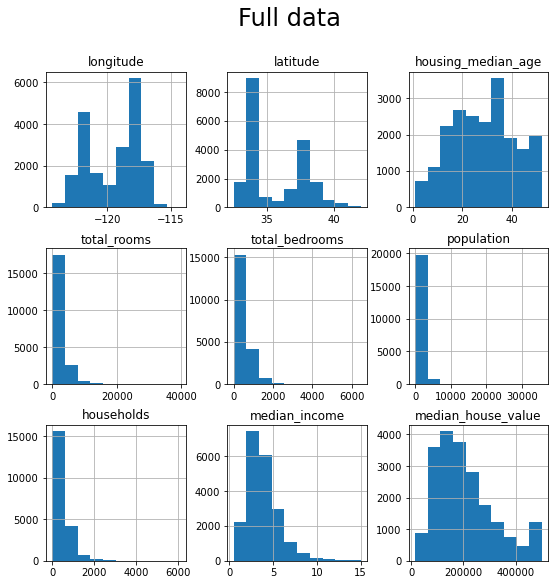

<Figure size 432x288 with 0 Axes>

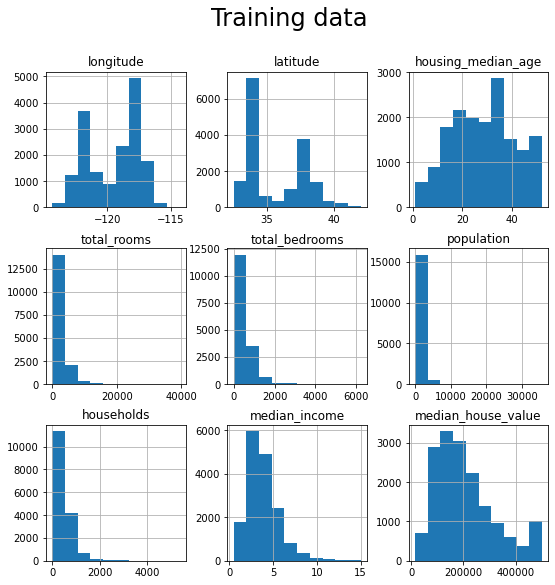

In [4]:
#print(np.shape(housing))
bins=np.arange(6)*1.0+.5

d0=housing["income_cat"]
hd0=np.histogram(d0,bins=bins)
print(hd0[0]/len(d0))

fig=plt.figure(1)
housing.hist(figsize=(9,9))
#plt.title("Full data")
plt.suptitle("Full data",fontsize=24)
plt.show()
fig=plt.figure(2)
strat_train_set.hist(figsize=(9,9))
plt.suptitle("Training data",fontsize=24)
plt.show()

## Replace 'housing' pd frame with training data

In [5]:

# Copy training set back to 'housing'
# Also 'drop' learning target from training set.
housing = strat_train_set.drop("median_house_value", axis=1 )

# In ML book this object was called 'housing_labels'
# which is a confusing name. Probably derved from categorical
# ML problem where the learning target is a 'label'.
# In any case, this is just a Pandas Series copied from the 
# 'strat_train_set' DataFrame.
housing_median_value = strat_train_set["median_house_value"].copy()

# Now copy 'housing' to 'housing_num' while executing 
# 'drop' of the categorical variable 'ocean_proximity'
housing_num = housing.drop("ocean_proximity", axis=1 )

In [6]:
strat_train_set.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'income_cat'],
      dtype='object')

In [7]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'income_cat'],
      dtype='object')

### These Pandas objects hide lots of information.  
### 'housing_median_value' is a 'Series' which has an index field and a values field.  
### So then for example

plt.plot(housing_median_value)

### is equivalent to 

plt.plot(housing_median_value.index,housing_median_value.values)

(16512,)


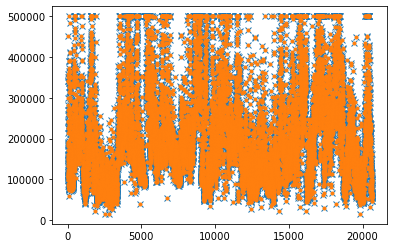

In [8]:
plt.plot(housing_median_value.index, housing_median_value.values,'x')
plt.plot(strat_train_set['median_house_value'],'.')
print(np.shape(housing_median_value.index))

## Fancy plot

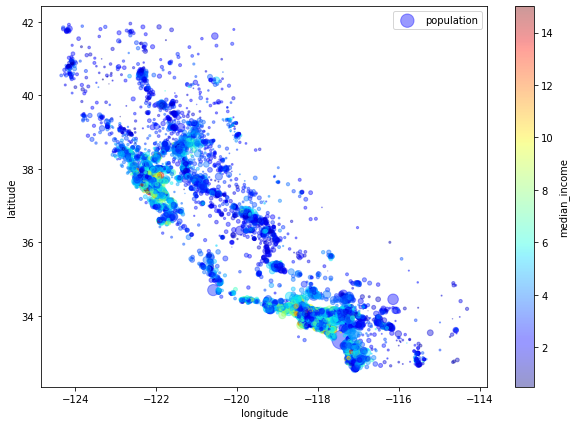

In [9]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_income", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()

#save_fig("housing_prices_scatterplot")


In [10]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)
housing_cat.columns

Index(['ocean_proximity'], dtype='object')

In [11]:
#import importlib
#importlib.reload(CAA)

imputer = SimpleImputer( strategy = "median" )

imputer.fit( housing_num )

X=imputer.transform( housing_num )  # X is an np ndarray


#attr_adder = CAA(add_bedrooms_per_room=False)
#housing_extra_attribs_values = attr_adder.transform(X)

In [12]:
print(np.shape(X))
#print(X[0:10,:])
#print(np.shape(housing_extra_attribs_values))

(16512, 9)


In [13]:

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CAA(add_bedrooms_per_room=True)),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

housing_num_tr_DF = pd.DataFrame(
    housing_num_tr,
    columns=list(housing_num.columns)+["rooms_per_household", "population_per_household","bedrooms_per_room"],
    index=housing.index)
housing_num_tr_DF.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat,rooms_per_household,population_per_household,bedrooms_per_room
12655,-0.941350,1.347438,0.027564,0.584777,0.640371,0.732602,0.556286,-0.893647,-0.954687,0.017395,0.006223,-0.121122
15502,1.171782,-1.192440,-1.722018,1.261467,0.781561,0.533612,0.721318,1.292168,1.890078,0.569256,-0.040811,-0.810867
2908,0.267581,-0.125972,1.220460,-0.469773,-0.545138,-0.674675,-0.524407,-0.525434,-0.954687,-0.018024,-0.075371,-0.338273
14053,1.221738,-1.351474,-0.370069,-0.348652,-0.036367,-0.467617,-0.037297,-0.865929,-0.954687,-0.595140,-0.106803,0.961205
20496,0.437431,-0.635818,-0.131489,0.427179,0.272790,0.374060,0.220898,0.325752,-0.006432,0.251241,0.006109,-0.474513


In [14]:
print(np.shape(housing_num_tr))

(16512, 12)


In [15]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [16]:
print(np.shape(housing_prepared))
XX=np.asarray(housing_num)

(16512, 17)


3.875884278100775
1.9048728343261887


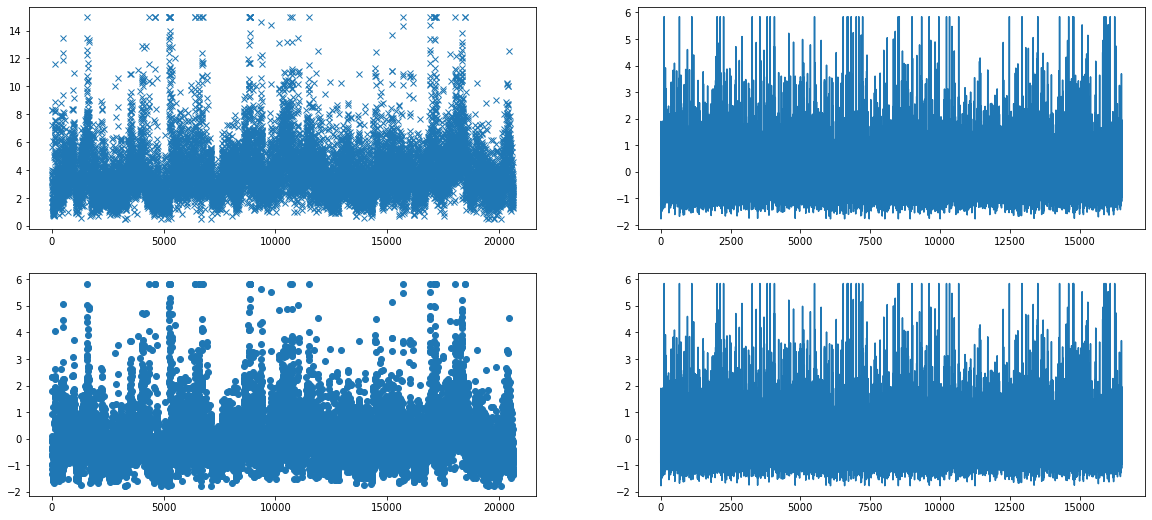

In [17]:
fig=plt.figure(figsize=(20,9))

ax=fig.add_subplot(2,2,1)
p1=ax.plot(housing_num['median_income'],'x')
ax=fig.add_subplot(2,2,2)
p2=ax.plot(housing_num_tr[:,7])
ax=fig.add_subplot(2,2,3)
p3=ax.plot(housing_num_tr_DF['median_income'],'o')
ax=fig.add_subplot(2,2,4)
p4=ax.plot(housing_prepared[:,7])

his=np.histogram(XX[:,7])
print(np.mean(XX[:,7]))
print(np.std(XX[:,7]))


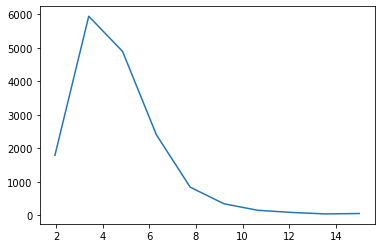

In [18]:
plt.plot(his[1][1:],his[0])

Now test out some ML models ...

In [19]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_median_value)

RandomForestRegressor(random_state=42)

In [20]:
housing_prediction=forest_reg.predict(housing_prepared)

In [23]:
np.shape(housing_median_value)

(16512,)

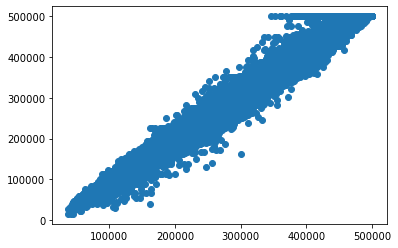

In [24]:
plt.scatter(housing_prediction,housing_median_value)

In [26]:
error=mean_squared_error(housing_prediction,housing_median_value)

In [28]:
print(np.sqrt(error))

18675.224916252282


In [32]:
#This cell takes a while to finish

scores = cross_val_score(forest_reg, housing_prepared, housing_median_value,
                         scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display(forest_rmse_scores)

array([51553.65292335, 48797.89565614, 47005.23947642, 52046.73567245,
       47700.78025873, 51824.08544879, 52582.59165129, 49949.79025967,
       48680.25622229, 54019.67674791])